# Notebook Sections: 
* [Setup](#setup)
* [Data Retrival](#retrive_data)
    - [Parse Data File](#parse_data)
* [Plotting Section](#plotting_section)

<a id="setup"></a>
# Setup 

In [118]:
import sys
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import json
import numpy as np
import pickle 

%matplotlib notebook

## Path to Data File Output by Realtime Parser
# path = "./crex2_int/day10/"
# file_name = "data_file_115k_usbserial-FT5RIYEN3-20210827_gps_rollout.txt"

path = "./"
file_name = "data/20220215T153711_data_COM7_230400_pfrr-sequence01_26.bin"

## Option to use parsed data for plots IF have already parsed the specified file and saved as pickle file.
use_pickle = False ## Specifies whether to use parsed data from pickle file [True] or to parse data in original text file [False].

dataFile = path + file_name

DeltInx=[100, 300, 200]

tref_type = "Reg" # The time reference type for the time data. "Flight" gives the time referenced to T0 whereas "Reg" gives time referenced to loop start time.  
flightData = False # Specifies if the data was collected during a rocket flight or not 
##############################################################
## Various Time corrections (Set for Delamere Flight Values)
# Dictionary containing the T0 times referenced shield's "start" time 
T0_dct = {14: 588.328, 16: 577.271, 18: 572.732, 19: 572.732, 20: 572.732, 21: 572.732}
##############################################################

class IMUData():
    def __init__(self):

        self.time = []; self.temp = []
        self.ax = []; self.ay = []; self.az = []
        self.mx = []; self.my = []; self.mz = []
        self.gx = []; self.gy = []; self.gz = []
        
class SweepData():
    def __init__(self):
        self.time = []
        self.pip0 = []; self.pip1 = [];
        
class PayloadData():
    def __init__(self):
        self.rawData = ''
        self.imu = IMUData()
        self.sweeps = SweepData()
        self.macAddress = ''
        self.rssiData = []
        self.shieldID = 0
        
# Functions for merging bytes
def combine2(a, b):
    return (a << 8) | b
def combine4(a, b, c, d):
    return (a << 24) | (b << 16) | (c << 8) | d

# Functions for saving data
def convertDataToLists(dataSet):
    dataSet.imu.ax = dataSet.imu.ax.tolist()
    dataSet.imu.ay = dataSet.imu.ay.tolist()
    dataSet.imu.az = dataSet.imu.az.tolist()
    dataSet.imu.mx = dataSet.imu.mx.tolist()
    dataSet.imu.my = dataSet.imu.my.tolist()
    dataSet.imu.mz = dataSet.imu.mz.tolist()
    dataSet.imu.gx = dataSet.imu.gx.tolist()
    dataSet.imu.gy = dataSet.imu.gy.tolist()
    dataSet.imu.gz = dataSet.imu.gz.tolist()
    dataSet.imu.temp = dataSet.imu.temp.tolist()
    dataSet.imu.time = dataSet.imu.time.tolist()
    dataSet.sweeps.time = dataSet.sweeps.time.tolist()
    dataSet.sweeps.pip0 = dataSet.sweeps.pip0.tolist()
    dataSet.sweeps.pip1 = dataSet.sweeps.pip1.tolist()
    return dataSet

def makeJSONFile (fname, payloadData):
    f = open(fname, 'w')
    # Convert into lists and dictionaries for JSON storage
    payloadData = convertDataToLists(payloadData)
    JSONDict = {}
    # First the IMU data
    imu = payloadData.imu
    imuData = {"time":imu.time, "temp":imu.temp,
               "ax":imu.ax, "ay":imu.ay, "az":imu.az,
               "mx":imu.mx, "my":imu.my, "mz":imu.mz,
               "gx":imu.gx, "gy":imu.gy, "gz":imu.gz}
    JSONDict["imu"] = imuData
    # Then the sweep data
    sweeps = payloadData.sweeps
    sweepData = {"id":sweeps.payloadID, "time":sweeps.time, "pip0":sweeps.pip0, "pip1":sweeps.pip1}
    JSONDict["sweeps"] = sweepData

    json.dump(JSONDict, f)
    f.close()

# Padding time data (as lists)Z
def timefix(l, new, dt):   # l = time data as list, new = empty list, dt = delta t
    for t in l:
        if l.index(t) >= 2:
            # replace bad timewords
            if t - l[l.index(t) - 1] < 0 or t - l[l.index(t) - 1] > 1:
                l[l.index(t) - 1] = l[l.index(t) - 2] + dt
                t = l[l.index(t) - 1] + dt
                
def get_pickle4plot(path, file_name, tref_type):
    import pickle
    pklfname = path+"%sTime_ParsedData-%s.pkl" % (tref_type.capitalize(), file_name.partition(".")[0])
    pklf = open(pklfname, "rb")
    dct = pickle.load(pklf)
    shieldID=dct['shieldID']; imuList=dct['imuTime']
    ax=dct['ax']; ay=dct['ay']; az=dct['az']
    gx=dct['gx']; gy=dct['gy']; gz=dct['gz']
    mx=dct['mx']; my=dct['my']; mz=dct['mz']
    temp=dct['temp']; sweepList=dct['sweepTime']; pip0nA=dct['pip0nA']; pip1nA=dct['pip1nA']
    sweepSampleTime=dct['sweepTimeLn']; pip0L=dct['pip0VLn']; pip1L=dct['pip1VLn']
    pklf.close()
    del dct, pklf
    return (pklfname, shieldID, imuList, ax, ay, az, gx, gy, gz, mx, my, mz, temp, sweepList, pip0nA, pip1nA, sweepSampleTime, pip0L, pip1L)

<a id="retrive_data"></a>
# Data Retrival

In [119]:
########### Load Pickle File ##############
if use_pickle: 
    pkl_data = get_pickle4plot(path, file_name, tref_type)
    pklfname, shieldID, imuList, ax, ay, az, gx, gy, gz, mx, my, mz, temp, sweepList, pip0nA, pip1nA, sweepSampleTime, pip0L, pip1L = pkl_data
    del pkl_data
#     pklfname = path+"ParsedData_wDInx%sto%s-%s.pkl" % (DeltInx[0], DeltInx[1], file_name.partition(".")[0])
#     pklf = open(pklfname, "rb")
#     dct = pickle.load(pklf)
#     shieldID=dct['shieldID']; imuPlot=dct['imuPlot']
#     axPlot=dct['axPlot']; ayPlot=dct['ayPlot']; azPlot=dct['azPlot']
#     gxPlot=dct['gxPlot']; gyPlot=dct['gyPlot']; gzPlot=dct['gzPlot']
#     mxPlot=dct['mxPlot']; myPlot=dct['myPlot']; mzPlot=dct['mzPlot']
#     tempPlot=dct['tempPlot']; sweepPlot=dct['sweepPlot']; pip0Plot=dct['pip0Plot']; pip1Plot=dct['pip1Plot']
#     sweepTimeLPlot=dct['sweepTimeLPlot']; pip0LPlot=dct['pip0LPlot']; pip1LPlot=dct['pip1LPlot']
#     pklf.close()
#     del dct
#     magfullPlot = mxPlot**2+myPlot**2+mzPlot**2
    print("Pickle File %s Loaded. \n\nProcceed Directly to \"Plotting Section\" of Notebook!")
else: 
    print("Using Data File Output from Realtime Parser. \n\nContinue to \"Parse Data File\" Section")

Using Data File Output from Realtime Parser. 

Continue to "Parse Data File" Section


<a id="parse_data"></a>
## Parse Data File

In [120]:
########### Load the data file ###########
f = open(dataFile, 'rb')
rawData = f.read()
print("Opened file:", dataFile)

# Create payload objects and store parsed data
mainPIPData = PayloadData()
mainPIPData.rawData = rawData
payloads = [mainPIPData]

########### Parse by data type for each payload ###########
strict_parse = False # Require a pound symbol at the end of the data
for payload in payloads:
    payloadrawData = payload.rawData
    imu = []
    sweeps = []
    # 2 PIPs with 28 2-byte samples + 4-byte timestamp + ID
    sweepSamples = 28
    numSweepBytes = sweepSamples * 2 * 2 + 4 + 1
    # 9 2-byte data points + 2-byte temp + 4-byte timestamp
    numIMUBytes = 24
    
    pntr = 0
    while pntr < len(payloadrawData):
        # Check message start sentinels and not at end
        if payloadrawData[pntr] == 35 and (len(payloadrawData)-pntr) >= numIMUBytes:
            if payloadrawData[pntr+1] == 73:
                # If not the last, check message end sentinel
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == 35:
                        imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                # Or just add the last message
                else:
                    imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 83:
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == 35:
                        sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
            else:
                pntr += 1
        else:
            pntr += 1
    print("Num IMU Messages: %s" %len(imu))
    print("Num Sweep Messages: %s" %len(sweeps))

    ########### Build data structures ###########
    # First the IMU/IMU Buffer
    imuTime = [];
    ax = []; ay = []; az = []
    mx = []; my = []; mz = []
    gx = []; gy = []; gz = []
    temp = [];
    
    for i in imu:
        if len(i) == numIMUBytes:
            imuTime.append(combine4(i[3], i[2], i[1], i[0]))
            # The byte order is reversed, but the data sets are not
            ax.append(combine2(i[5], i[4]))
            ay.append(combine2(i[7], i[6]))
            az.append(combine2(i[9], i[8]))
            mx.append(combine2(i[11], i[10]))
            my.append(combine2(i[13], i[12]))
            mz.append(combine2(i[15], i[14]))
            gx.append(combine2(i[17], i[16]))
            gy.append(combine2(i[19], i[18]))
            gz.append(combine2(i[21], i[20]))
            temp.append(combine2(i[23], i[22]))
    
    imuTime = np.array(imuTime, dtype='uint32')
    ax = np.array(ax, dtype='int16')
    ay = np.array(ay, dtype='int16')
    az = np.array(az, dtype='int16')
    mx = np.array(mx, dtype='int16')
    my = np.array(my, dtype='int16')
    mz = np.array(mz, dtype='int16')
    gx = np.array(gx, dtype='int16')
    gy = np.array(gy, dtype='int16')
    gz = np.array(gz, dtype='int16')
    temp = np.array(temp, dtype='int16')

    payload.imu.time = imuTime
    payload.imu.ax = ax
    payload.imu.ay = ay
    payload.imu.az = az
    payload.imu.mx = mx
    payload.imu.my = my
    payload.imu.mz = mz
    payload.imu.gx = gx
    payload.imu.gy = gy
    payload.imu.gz = gz
    payload.imu.temp = temp

    # Then the sweeps
    payloadID = [];
    sweepTime = []
    allSweepsPIP0 = []
    individualSweepsPIP0 = []
    allSweepsPIP1 = []
    individualSweepsPIP1 = []
    PIP0StartByte = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByte = PIP0StartByte + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByte = PIP0StopByte + sweepSamples*2      # Number of samples, two bytes each
    
    for i in sweeps:
        if len(i) == numSweepBytes:
            sweepTime.append(combine4(i[3], i[2], i[1], i[0]))
            payloadID.append(i[4])
            tempSweep = []
            for byte in range(PIP0StartByte,PIP0StopByte,2):
                allSweepsPIP0.append(combine2(i[byte+1], i[byte]))
                tempSweep.append(combine2(i[byte+1], i[byte]))
            individualSweepsPIP0.append(tempSweep)
            tempSweep = []
            for byte in range(PIP0StopByte,PIP1StopByte,2):
                allSweepsPIP1.append(combine2(i[byte+1], i[byte]))
                tempSweep.append(combine2(i[byte+1], i[byte]))
            individualSweepsPIP1.append(tempSweep)
                       
    payloadMatch = (len(set(payloadID)) == 1)
    if payloadMatch:
        print("Payload ID's match. This was payload #%s." %payloadID[0])
    else:
        print("Payload ID's don't match. Something went wrong...")
        
    sweepTime = np.array(sweepTime, dtype='uint32')
    individualSweepsPIP0 = np.array(individualSweepsPIP0, dtype='int16')
    individualSweepsPIP1 = np.array(individualSweepsPIP1, dtype='int16')
    payload.shieldID = payloadID[0]
    payload.sweeps.time = sweepTime
    payload.sweeps.pip0 = individualSweepsPIP0
    payload.sweeps.pip1 = individualSweepsPIP1

Opened file: ./data/20220215T153711_data_COM7_230400_pfrr-sequence01_26.bin
Num IMU Messages: 35016
Num Sweep Messages: 35013
Payload ID's don't match. Something went wrong...


In [121]:
################################## Forming and Scaling Data ##################################### 

sweepSize = 28
sweepStepDt = 0.02 / sweepSize

# Define as None for no limits
timeMin = None # 485 produces better plots than 480
timeMax = None

# Set by the time limits automatically
timesToSkip = 30 # To impove the quality of sample numbering selection
IMUSampleMin = None
IMUSampleMax = None
SweepSampleMin = None
SweepSampleMax = None

for payload in payloads:
    # Extract data from each set, cast into arrays
    aScale = 4*9.8; mScale = 1.; gScale = 2000./360
    
    imuTime = np.array(payload.imu.time)/1.E6;
    sweepTime = np.array(payload.sweeps.time)/1.E6
    
    # Figure out what the sample bounds should be
    if timeMin:
        IMUSampleMin = np.where(imuTime>=timeMin)[0][timesToSkip]
        IMUSampleMax = np.where(imuTime<=timeMax)[0][-1 * timesToSkip]
        SweepSampleMin = np.where(sweepTime>=timeMin)[0][timesToSkip]
        SweepSampleMax = np.where(sweepTime<=timeMax)[0][-1 * timesToSkip]
    imuTime = imuTime[IMUSampleMin:IMUSampleMax]
    sweepTime = sweepTime[SweepSampleMin:SweepSampleMax]
     
    # Make everything an array
    
    temp = payload.imu.temp[IMUSampleMin:IMUSampleMax];
    ax = np.array(payload.imu.ax[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ay = np.array(payload.imu.ay[IMUSampleMin:IMUSampleMax])*aScale/2**15
    az = np.array(payload.imu.az[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mx = np.array(payload.imu.mx[IMUSampleMin:IMUSampleMax])*mScale/2**15
    my = np.array(payload.imu.my[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mz = np.array(payload.imu.mz[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gx = np.array(payload.imu.gx[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gy = np.array(payload.imu.gy[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gz = np.array(payload.imu.gz[IMUSampleMin:IMUSampleMax])*gScale/2**15
    shieldID = payload.shieldID
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    
    print("Data Scaled")
############################ Padding Data #######################################

    # Change time data to list form for padding
    imuList = imuTime.tolist()
    sweepList = sweepTime.tolist()
    
    # Find correct delta t
    imuDelt = round(((imuList[DeltInx[1]] - imuList[DeltInx[0]]) / DeltInx[2]), 4)
    sweepDelt = round(((sweepList[DeltInx[1]] - sweepList[DeltInx[0]]) / DeltInx[2]), 4)
    
    print("Deltas found")
    
    newImuTime =  []
    newSweepTime = []
    
    # iterate through IMU twice to better fill gaps
    timefix(imuList, newImuTime, imuDelt)
    timefix(imuList, newImuTime, imuDelt)
    print("IMU Done")
    
    # iterate through sweep
    timefix(sweepList, newSweepTime, sweepDelt)
    timefix(sweepList, newSweepTime, sweepDelt)
    print("Sweep Done")
    
    # change back to array
    imuList = np.array(imuList)
    sweepList = np.array(sweepList)
    
    if tref_type.capitalize() == 'Flight': 
        imuList = imuList - T0_dct[shieldID]
        sweepList = sweepList - T0_dct[shieldID]    
    
    # reshape all data
    ax = np.reshape(ax, (len(ax), 1))
    ay = np.reshape(ay, (len(ay), 1))
    az = np.reshape(az, (len(az), 1))
    gx = np.reshape(gx, (len(gx), 1))
    gy = np.reshape(gy, (len(gy), 1))
    gz = np.reshape(gz, (len(gz), 1))
    mx = np.reshape(mx, (len(mx), 1))
    my = np.reshape(my, (len(my), 1))
    mz = np.reshape(mz, (len(mz), 1))
    temp = np.reshape(temp, (len(temp), 1))
       
    ############################################################
    ##Bringing in from parse_erpabob-2 to use for lineplots
    # Flatten out sweepSampleTime 
    sweepSampleTime = []
#     for t in sweepTime:
    for t in sweepList:
        for n in range(0, sweepSize):
            sweepSampleTime.append(t+sweepStepDt*n)
    sweepSampleTime = np.array(sweepSampleTime)
    
    pip0L = np.array(payload.sweeps.pip0)*5./2**14
    pip1L = np.array(payload.sweeps.pip1)*5./2**14
    pip1L = pip1L.flatten();
    pip0L = pip0L.flatten();
    ############################################################
    
    print("All Done")

Data Scaled
Deltas found
IMU Done
Sweep Done
All Done


In [122]:
import os
os.system("say 'Done parsing data'")

1

In [123]:
# Changes screen voltage to nA
# ** Set for LAMP shield values right now **

highV2I = 1.0/(320.0E-3)
lowV2I = 1.0/(150.0E-3)
# lowV2I = 1.0/(40.0E-3)
# lowV2I = 1.0/(120.0E-3)

# # ** LAMP shield values ** #
if np.any(shieldID == np.array([22, 23, 24, 25])): 
    pip0V2I = highV2I
    pip1V2I = highV2I
elif np.any(shieldID == np.array([26])):
    pip0V2I = lowV2I
    pip1V2I = lowV2I
else:
    pip0V2I = highV2I
    pip1V2I = highV2I

# # # ** CREX-2 shield values ** #
# highV2I = 1.0/(320.0E-3)
# lowV2I = 1.0/(160.0E-3)
# if np.any(shieldID == np.array([8, 10])): 
#     pip0V2I = highV2I
#     pip1V2I = highV2I
# elif np.any(shieldID == np.array([9, 11])):
#     pip0V2I = lowV2I
#     pip1V2I = lowV2I
    
# # ** Delamere shield values ** #
# if np.any(shieldID == np.array([14, 16, 17, 22])):
#     pip0V2I = highV2I
#     pip1V2I = lowV2I
# elif np.any(shieldID == np.array([18, 21])): 
#     pip0V2I = lowV2I
#     pip1V2I = lowV2I
# else: #Shield 19 and 20 
#     pip0V2I = highV2I
#     pip1V2I = highV2I
    
pip0nA = (pip0-1)*pip0V2I
pip1nA = (pip1-1)*pip1V2I

In [124]:
# #### Save Pickle File ####
# dct = dict()
# version="Original"
# dct['shieldID']=shieldID;
# dct['imuPlot']=imuList; dct['axPlot']=axPlot=ax; dct['ayPlot']=ay; dct['azPlot']=az
# dct['gxPlot']=gx; dct['gyPlot']=gy; dct['gzPlot']=gz; dct['mxPlot']=mx; dct['myPlot']=my; dct['mzPlot']=mz
# dct['tempPlot']=temp; dct['sweepPlot']=sweepList; dct['sweepTimeLPlot']=sweepSampleTime
# dct['pip0Plot']=pip0nA; dct['pip1Plot']=pip1nA; dct['pip0LPlot']=pip0L; dct['pip1LPlot']=pip1L
# pklfname = path+"ParsedData_wDInx%sto%s-%s-%s.pkl" % (DeltInx[0], DeltInx[1], file_name.partition(".")[0], version)
# pklf = open(pklfname, "wb"); pickle.dump(dct, pklf); pklf.close()
# print pklfname
# del pklf, pklfname, dct
# print pklfname
#### Save Pickle File ####
# dct = dict()
# dct['parent_file'] = dataFile; dct['DeltInx']=DeltInx
# dct['shieldID']=shieldID; 
# dct['imuTime']=imuList; dct['temp']=temp; dct['ax']=axPlot=ax; dct['ay']=ay; dct['az']=az
# dct['gx']=gx; dct['gy']=gy; dct['gz']=gz; dct['mx']=mx; dct['my']=my; dct['mz']=mz
# dct['sweepTime']=sweepList; dct['sweepTimeLn']=sweepSampleTime; dct['sweepSize']=sweepSize; dct['sweepStepDt']=sweepStepDt
# dct['pip0nA']=pip0nA; dct['pip1nA']=pip1nA; dct['pip0VLn']=pip0L; dct['pip1VLn']=pip1L
# dct['pip0V2I']=pip0V2I; dct['pip1V2I']=pip1V2I
# if flightData: dct['shield_T0'] = T0_dct[shieldID]
# else: dct['shield_T0'] = 0
# if tref_type.capitalize=='Flight': dct['applied_T0'] = True
# else: dct['applied_T0'] = False
# pklfname = path+"%sTime_ParsedData-%s.pkl" % (tref_type.capitalize(), file_name.partition(".")[0])
# pklf = open(pklfname, "wb"); pickle.dump(dct, pklf); pklf.close()
# print pklfname
# del pklf, pklfname, dct

<a id="plotting_section"></a>
# Plotting Section

In [125]:
imuPlot = imuList
axPlot = ax
ayPlot = ay
azPlot = az
gxPlot = gx
gyPlot = gy
gzPlot = gz
mxPlot = mx
myPlot = my
mzPlot = mz
magfullPlot = mxPlot**2+myPlot**2+mzPlot**2
tempPlot = temp
sweepPlot = sweepList
pip0Plot = pip0nA
pip1Plot = pip1nA 

pip0LPlot = pip0L
pip1LPlot = pip1L
sweepTimeLPlot = sweepSampleTime

In [126]:
# xlims = [1100, 1250]
# xlims = [480, 540] #vibeXrand
# xlims = [370, 430] #vibeYrand
# xlims = [370, 440] #vibeZrand
# xlims = [400, 570]

# xlims2 = xlims
ylims = [0.99, 1.02]
ylims =[0, 2]
# ylims = [0.7, 1.3]
ylims2 = ylims
cplt_kwargs={'pip0': {'vmin':0, 'vmax':0.05}, 'pip1':{'vmin':0, 'vmax':0.05}}

xlims, xlims2 = None, None
# ylims, ylims2 = None, None
# cplt_kwargs = {'pip0': {}, 'pip1':{}}

<IPython.core.display.Javascript object>


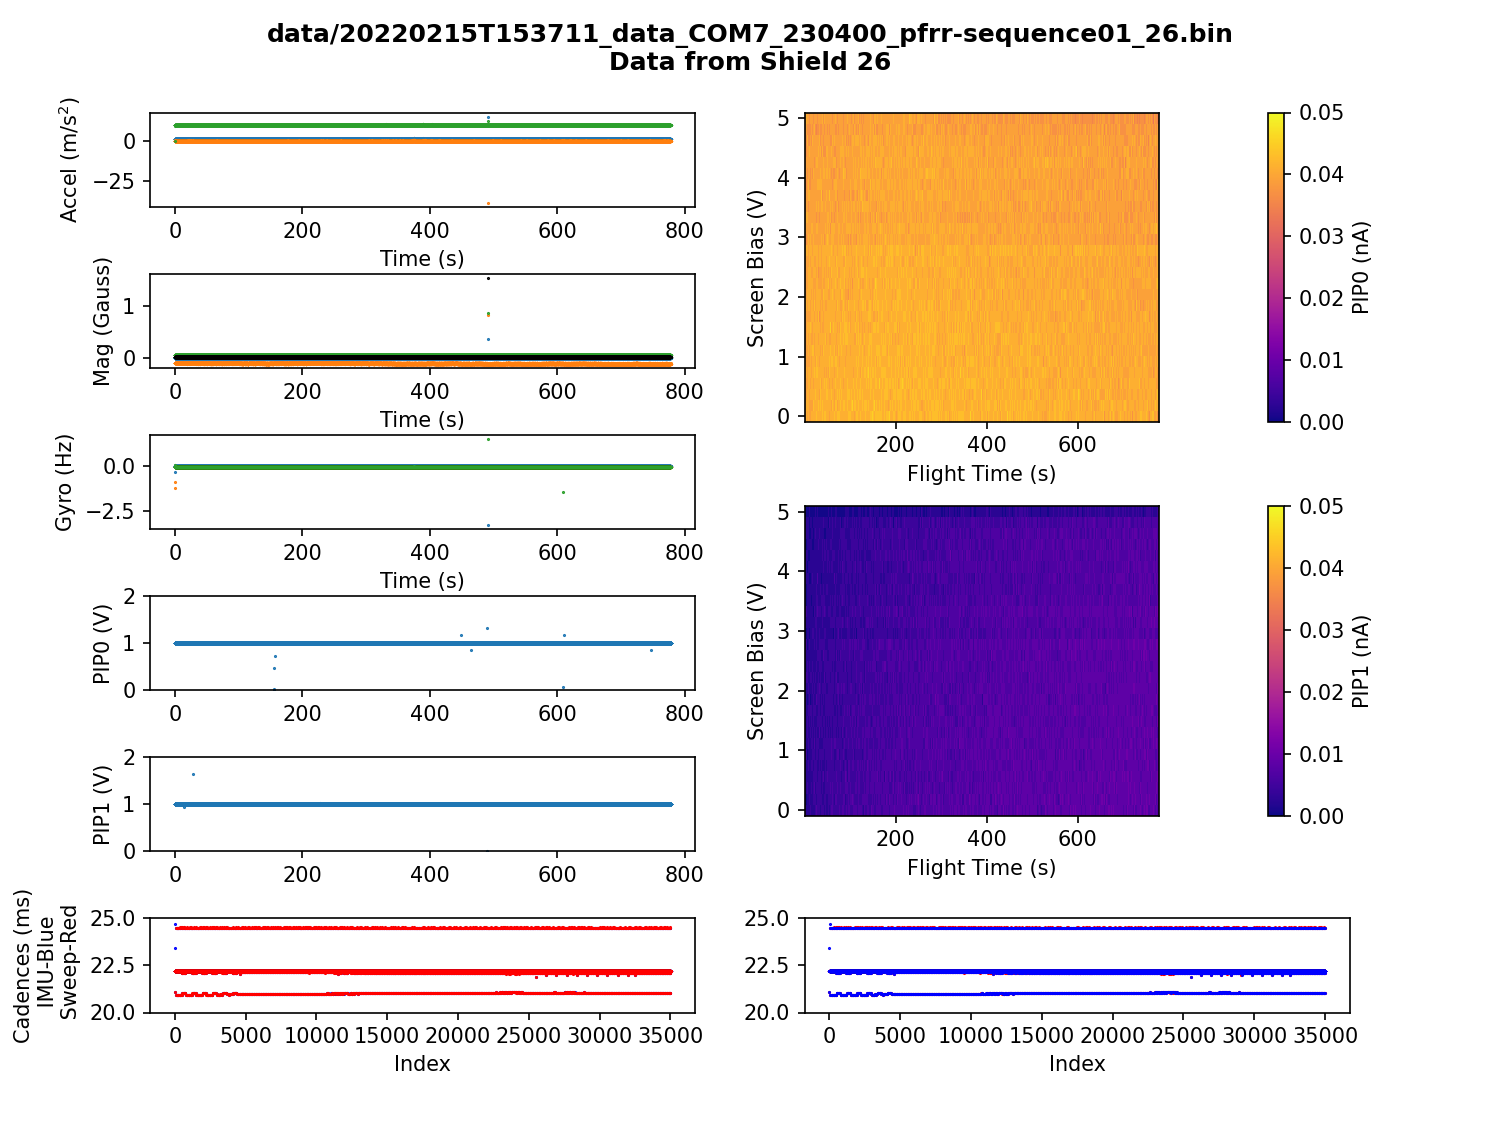

1 Done
2 Done
3 Done
4 Done
5 Done
6 Done
7 Done
8 Done
9 Done
plots/20220215T153711_data_COM7_230400_pfrr-sequence01_26.png


In [127]:
matplotlib.use('nbagg')
import matplotlib.cm as cm
import scipy.signal as sig
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat
from __future__ import division

dots = True

gs_left = plt.GridSpec(6, 2,  hspace=0.7)

# Set up dots or not more cleanly
line_style = '-'
if dots:
    line_style = '.'

markersize = 1

fig = plt.figure(figsize=(10, 7.5))

# Accel
axis1 = fig.add_subplot(gs_left[0,0])
plt.plot(imuPlot, axPlot, line_style, markersize=markersize, label='ax') 
plt.plot(imuPlot, ayPlot, line_style, markersize=markersize, label='ay')  
plt.plot(imuPlot, azPlot, line_style, markersize=markersize, label='az') 
plt.ylabel("Accel (m/s$^2$)")
#plt.ylim([-2, 2])
#plt.xlim([75, 100])
plt.xlabel("Time (s)")
print ("1 Done")

# Mag
fig.add_subplot(gs_left[1,0], sharex=axis1)
plt.plot(imuPlot, mxPlot, line_style, markersize=markersize, label='mx') 
plt.plot(imuPlot, myPlot, line_style, markersize=markersize, label='my')  
plt.plot(imuPlot, mzPlot, line_style, markersize=markersize, label='mz') 
plt.plot(imuPlot, magfullPlot, line_style, markersize=markersize, color='black', label='magfull')
#plt.ylim([-0.2, 0.25])
plt.ylabel("Mag (Gauss)")
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("2 Done")

# Gyro
fig.add_subplot(gs_left[2,0], sharex=axis1)
plt.plot(imuPlot, gxPlot, line_style, markersize=markersize, label='gx') 
plt.plot(imuPlot, gyPlot, line_style, markersize=markersize, label='gy')  
plt.plot(imuPlot, gzPlot, line_style, markersize=markersize, label='gz') 
plt.ylabel("Gyro (Hz)")
#plt.ylim([-0.5, 0.5])  
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("3 Done")

# First PIP (line)
fig.add_subplot(gs_left[3,0], sharex=axis1)
plt.plot(sweepTimeLPlot, pip0LPlot, line_style, markersize=markersize)
plt.ylabel("PIP0 (V)")
plt.ylim(ylims)
#plt.ylim([1.0075, 1.0125])
plt.xlim(xlims)
print("4 Done")

# Second PIP (line)
fig.add_subplot(gs_left[4,0], sharex=axis1)
plt.plot(sweepTimeLPlot, pip1LPlot, line_style, markersize=markersize)
#plt.ylim([1.027, 1.033])
plt.ylim(ylims2)
plt.xlim(xlims2)
plt.ylabel("PIP1 (V)")
print("5 Done")

# Cadence (sweep on top)
axis2 = fig.add_subplot(gs_left[5,0])
plt.plot(np.diff(imuPlot*1E3), line_style, color='blue', markersize=markersize)
plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
plt.ylim([20,25])
#plt.xlim([200,400])
plt.ylabel("Cadences (ms)\n IMU-Blue\n Sweep-Red")
plt.xlabel("Index")
print ("6 Done")

# Cadence (imu on top)
fig.add_subplot(gs_left[5,1], sharex=axis2, sharey=axis2)
plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
plt.plot(np.diff(imuPlot*1E3), line_style, color='blue', markersize=markersize)
plt.ylim([20,25])
#plt.xlim([200,400])
plt.xlabel("Index")
print ("7 Done")
    
# **Plot sweep time vs sweep data (Color plots)**

# commands to reorient pip array to match with other axes
pip0_rot = np.rot90(pip0Plot, k=1, axes=(0, 1))
pip1_rot = np.rot90(pip1Plot, k=1, axes=(0, 1))

sweep_voltage = np.linspace(0,5,28)

line_style = '-'

ax1 = plt.subplot2grid((5,2),(0,1),rowspan = 2)
plt.pcolormesh(sweepPlot, sweep_voltage, pip0_rot, cmap='plasma', **cplt_kwargs['pip0'])
plt.xlim(xlims)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP0 (nA)")
print ("8 Done")

ax1 = plt.subplot2grid((5,2),(2,1),rowspan = 2, sharex=ax1)
plt.pcolormesh(sweepPlot, sweep_voltage, pip1_rot, cmap='plasma', **cplt_kwargs['pip1'])
plt.xlim(xlims2)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP1 (nA)")
print ("9 Done")
        
# Adjust figure
fig.subplots_adjust(right=.90)
fig.subplots_adjust(left=0.10)
fig.subplots_adjust(top=0.90)
fig.subplots_adjust(bottom=0.10)
fig.subplots_adjust(hspace=0.75)
    
plt.suptitle(file_name+"\n"+"Data from Shield %s" 
             %(shieldID), fontweight='bold')
    
plt.show()
plt.savefig("plots"+file_name[4:-4]+".png")
print("plots"+file_name[4:-4]+".png")


In [19]:
### IMU Color Key ###
# x-values: blue 
# y-values: orange 
# z-values: Green